# Abstract

L'obiettivo di questo notebook é quello di produrre un ambiente di cache simulata per testare in maniera efficiente (e soprattutto piu dinamica di valgrind) gli algoritmi e gli eventuali miglioramenti in ambito di performance della cache.
Inoltre, la possibilitá di variare i parametri della Memoria, permette di simulare diverse architetture mettendo a disposizione cosí la possibilitá di produrre delle metriche che siano il piu possibile generali e non vincolate alla macchina su cui vengono eseguiti i test


In [1]:
import numpy  as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Simulazione della memoria

Costruiamo una classe che astrae il comportamento di una Memoria fisica. <br>
La Memoria fisica che simuliamo ha un comportamento estremamente semplice. Essa rappresenta i dati, a livello interno dell'oggetto, come <b> blocchi </b> divisi in <b> celle </b>. Questa divisione si presenta estremamente "comoda" dal momento che presenta una separazione esplicita dei blocchi. Ad ogni modo <b> per garantire uniformitá con il modello fisico di memoria a cui siamo abituati </b> l'accesso dall'esterno avviene mediante <b> indirizzo </b>. In particolare i metodi $read$ e $write$ avvengono tramite indirizzo ( $\in \mathbb N_+$ ), che viene mappato - internamente - mediante il metodo $abstract\_address$.
L'utilizzatore della memoria utilizza quindi la memoria nel modo classico , in maniera agnostica rispetto alla divisione blocchi / celle. Nell'esempio presentato ogni cella contiene un singolo <b> byte </b>

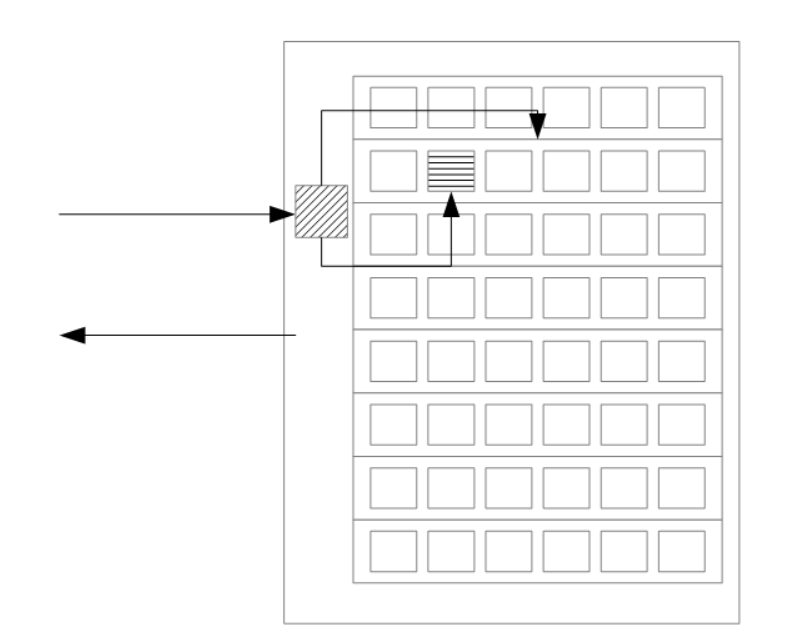
<i><center> Astrazione fisica della memoria : si immagina <br> che l'indirizzo fornito dall esterno venga tradotto itnernamente come una coppia blocco - cella</center></i>

In [2]:
class Memory:
    def __init__(self, 
                 blocks,       # numero di blocchi in memoria
                 block_size    # dimensione in byte di un blocco
                ):
        # i dati sono astratti come elementi di una matrice in modo da rendere 
        # esplicita la divisione in blocchi della memoria. Il tipo "np.uint8" garantisce che ogni cella sia effettivamente un byte
        self.data = np.zeros((blocks, block_size)).astype(np.uint8)  
        self.blocks = blocks
        self.block_size = block_size
    
    def abstract_address(self,address):
        # IN : indirizzo unidimensionale (astrazione fisica della memoria)
        # OUT: indirizzo bidimensionale (astrazione software, trasparente all'utente)
        return  ( int(address / self.block_size) , address % self.block_size)        
    
    def read(self,
             address
            ):
        # IN  : un indirizzo di memoria
        # OUT : un valore
        
        ### calcolo la posizione nella matrice astratta
        x , y = self.abstract_address(address)
        ### ritorno il valore
        return self.data[x,y]
        
    def write(self,
             address,
             value
             ):
        # IN  : un indirizzo di memoria e un byte
        # OUT : void
        
        ### calcolo la posizione nella matrice astratta
        x , y = self.abstract_address(address)
        ### ritorno il valore
        self.data[x,y] = value
        
    def get_block(self,
                  address
                 ):
        # IN : un indirizzo 
        # OUT: il vettore che rappresenta il contenuto del blocco
        
        x , y = self.abstract_address(address)
        return self.data[x]
    
    def set_block(self,
                 address,
                 vector
                 ):
        # IN : un indirizzo, un vettore di valori
        # OUT: sovrascrive il blocco a cui appartiene l'indirizzo sovrapponendo il contenuto del vettore di valori
        
        x , y = self.abstract_address(address)
        self.data[x] = vector

Proviamo a scrivere un valore in memoria ed estrarre il blocco che contiene il valore appena scritto

In [3]:
M = Memory(100000,64)
addr = 10052
M.write(addr, 15)
M.get_block(addr)

array([ 0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=uint8)

# Simulazione della Cache - Fully Associative

Immaginando la cache come un oggetto che eredita le proprietá delle memorie (essendo fisicamente parlando una memoria), costruiamo una classe Cache, che arricchisce la nozione di Memoria fisica con le proprietá caratterizzanti della cache

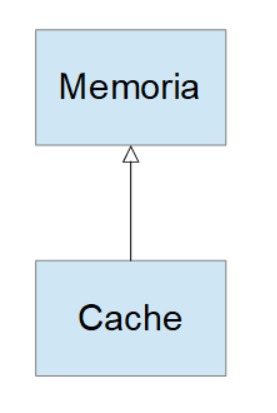

In [4]:
class Cache(Memory):
    # La cache simulata é fully associative ; la politica di replacemente é LRU
    # La scrittura non viene trattata dal momento che non é rilevante per l'esperimento
    def __init__(self,   
                blocks,        # numero di blocchi nella cache
                Mem           # puntatore alla memoria a cui si interfaccia
                ):
        #  /*   Implementa una simulazione della cache che fa da interfaccia a un unitá di memoria
        #   *   con cui comunica. Dal momento che la cache é a tutti gli effetti una memoria con alcune
        #   *   proprietá particolari , la classe viene trattata come figlia della Memory
        #   */
        self.Mem = Mem
        block_size = Mem.block_size               # la dimensione del blocco della cache dipende dalla memoria
        Memory.__init__(self,blocks, block_size) 
        
        self.addresses = -1 * np.ones((blocks, block_size)).astype(int)
        self.timestamps = np.zeros(blocks)
        
        # statistics
        self.accesses = 0
        self.hits   = 0
        self.misses = 0
        self.history = list()
    ############################################################    
    #  Gestione dello storico/statistica della cache           #
    ############################################################
    
    def hit(self):
        # gestisce il salvataggio dell'hit nella storia della cache
        self.hits += 1
    def miss(self):
        # gestisce il salvataggio del miss nella storia della cache
        self.misses += 1
    def access(self):
        # gestisce il salvataggio dell'accesso nella storia della cache
        self.accesses += 1
        self.history.append([self.hits,self.misses ])

    ############################################################    
    #  Flush                                                   #
    ############################################################  
    
    def flush(self):
        self.__init__(self.blocks, self.Mem)
        
    
    ############################################################    
    #  Lettura di un valore dalla cache                        #
    ############################################################
    
    def read(self,address):
        # IN  : un indirizzo di memoria
        # OUT : un valore
        
        #### Note : se l'indirizzo esiste in cache ritorna il valore, e incrementa gli hits.
        ####        altrimenti aumenta i miss e chiede alla memoria collegata il blocco collegato
        ####        all'indirizzo
        
        
        # cerco l'indirizzo nella lista degli indirizzi
        mask = ( 
            self.addresses == address
        )*1.
        
        # cerco il blocco nella lista
        blockmask = (np.array( self.addresses[:,0] / self.block_size ).astype(int) == int(address / self.block_size)) * 1.
        # verifico di trovarmi in una situazione di cold start
        cold_start = (self.timestamps == 0).all()        
        
        if( blockmask.sum() == 0 or cold_start):
            # il valore non é stato trovato
            # incremento il contatore degli accessi in memoria e dei miss
            self.access()
            self.miss()      
            # salvo l'indirizzo di inizio del blocco
            block_starting_address = int(address / self.block_size) * self.block_size 
            # ottengo il contenuto del blocco associato all'indirizzo corretto
            just_fetched_data = self.Mem.get_block(address)
            # seleziono il blocco con il timestamp piu piccolo per sovrascriverlo
            block_to_overwrite = self.timestamps.argmin()
            # sovrascrivo gli indirizzi ; i nuovi indirizzi sono l'insieme di indirizzi associati al blocco di appartenenza
            self.addresses[ block_to_overwrite ] = block_starting_address + np.arange(self.block_size)
            # sovrascrivo i dati
            self.data[ block_to_overwrite ] = just_fetched_data
            # aggiorno il timestamp
            self.timestamps[ block_to_overwrite ] = self.accesses
            return self.Mem.read(address)
        else:
            # il valore é stato trovato
            # incremento il contatore degli accessi in memoria e degli hit
            self.access()
            self.hit()
            # calcolo il blocco e il settore dell'idirizzo richiesto
            x , y = mask.argmax(axis = 0).sum() , mask.argmax(axis = 1).sum()
            # aggiorno il timestamp del blocco appena letto
            self.timestamps[ x ]  = self.accesses
            # ritorno il valore
            return self.data[x,y]         

In questo notebook, é trattato solo il caso della cache <b> Monolivello </b> ma dal momento che il costruttore di cache é compatibile anche con oggetti di classe cache (dal momento che la cache <b> estende </b> l'oggetto memoria) sarebbe virtualmente possibile costruire una cache che si interfaccia ad un altra cache, producendo quindi una struttura <b> Multilivello </b>

### Test - Accesso casuale alla memoria

Verifichiamo che sia tutto ok : accediamo casualmente a tutta la memoria, avendo una cache avente un numero di blocchi pari all'1% del numero di blocchi complessivo contenuto nella memoria principale. il risultato ottenuto risulta coerente con la teoria


In [5]:
M = Memory(1000,10)
C = Cache(10,M)
addr = 100 * 32
for i in range(10000):
    #addr = addr + (np.random.choice(2) * 2 - 1) * 5
    addr  = np.random.choice( M.blocks * M.block_size )
    if i % 100 == 0:
        print(" [%d] addr = %d \t \t hits = %d \t \t miss = %d " % (i,addr ,C.hits, C.misses ) )
    C.read( addr ) 

 [0] addr = 6233 	 	 hits = 0 	 	 miss = 0 
 [100] addr = 6136 	 	 hits = 1 	 	 miss = 99 
 [200] addr = 5009 	 	 hits = 1 	 	 miss = 199 
 [300] addr = 1553 	 	 hits = 2 	 	 miss = 298 
 [400] addr = 8789 	 	 hits = 3 	 	 miss = 397 
 [500] addr = 3615 	 	 hits = 3 	 	 miss = 497 
 [600] addr = 4715 	 	 hits = 4 	 	 miss = 596 
 [700] addr = 3733 	 	 hits = 4 	 	 miss = 696 
 [800] addr = 9158 	 	 hits = 5 	 	 miss = 795 
 [900] addr = 8395 	 	 hits = 5 	 	 miss = 895 
 [1000] addr = 4889 	 	 hits = 7 	 	 miss = 993 
 [1100] addr = 2450 	 	 hits = 7 	 	 miss = 1093 
 [1200] addr = 8086 	 	 hits = 7 	 	 miss = 1193 
 [1300] addr = 4849 	 	 hits = 7 	 	 miss = 1293 
 [1400] addr = 191 	 	 hits = 8 	 	 miss = 1392 
 [1500] addr = 2073 	 	 hits = 9 	 	 miss = 1491 
 [1600] addr = 4129 	 	 hits = 11 	 	 miss = 1589 
 [1700] addr = 9359 	 	 hits = 11 	 	 miss = 1689 
 [1800] addr = 1706 	 	 hits = 13 	 	 miss = 1787 
 [1900] addr = 8067 	 	 hits = 16 	 	 miss = 1884 
 [2000] addr = 6844 	 	

La politica $LRU$ viene applicata mediante l'uso di <b> timestamps </b> associati ai blocchi, che contengono l'informazione relativa a quanto valeva il numero totale di accessi in cache al momento della consultazione di ogni blocco. In questo modo siamo in grado di costruire un ordine di accesso tra i vari blocchi, dal momento che - ad esempio - il blocco con il timestamp minore rappresenta il blocco acceduto prima "cronologicamente"

In [6]:
C.timestamps

array([ 9993.,  9999., 10000.,  9996.,  9992.,  9997.,  9995.,  9998.,
        9994.,  9991.])

# Memory Stack
Implementazione di una memoria composita simulata<br>
$
CPU \rightarrow CACHE \rightarrow MEMORY
$

Produco una classe in grado di permettermi di accedere in a porzioni della memoria in maniera analoga ad un vettore.
Il signficato di questa classe sará piu chiaro nel momento che andremo a definire $MemoryUnit$. L'idea fondamentale é quella di costruire un oggetto che mi permetta di manipolare porzioni di memoria in maniera analoga a come verrebbe fatto con un oggetto di tipo $np.array$. Vogliamo quindi che nei nostri test, l'utilizzo di un memory vector richieda un intervento minimo da parte di chi scriverá codice, in modo da poter testare direttamente gli algoritmi senza la necessitá di manipolare ulteriormetne il codice, ma in maniera del tutto agnostica

In [6]:
class MemoryVector:
    def __init__(
        self,
        offset,           # inizio vettore
        length,           # fine vettore
        interface         # interfaccia alla memoria
    ):
        self.interface = interface
        self.length    = length
        self.offset    = offset
    
    def __getitem__(self, idx):
        if idx < 0 or idx >= self.length:
            raise Exception("Segmentation fault")
            
        address = self.offset + idx
        #print("reading address %d " % address)
        return self.interface.read(address)

    def __len__(self):
        return self.length

Modello lo stack della memoria

In [7]:
class MemoryUnit:
    def __init__(self,
                 block_size,         # dimensione in byte dei blocchi
                 blocks_memory,      # numero di blocchi in memoria
                 blocks_cache ):     # numero di blocchi in cache
        self.memory = Memory(blocks_memory, block_size)
        self.cache  = Cache(blocks_cache, self.memory)
        
    def memcopy(self,data):
        # IN : un vettore di dati
        # OUT: copia il vettore nella memoria a partire dall'indirizzo zero. Restituisce
        #      un oggetto di classe XXX che permette la lettura in memoria in maniera analoga ad un vettore
        
        # calcolo il padding per costruire la versione dei dati da copiare nella memoria
        padding  = len(data) % self.memory.block_size
        padding = (padding != 0) * ( self.memory.block_size - padding) 
        data_reshaped = (np.r_[data, np.zeros(padding)]).reshape(-1,self.memory.block_size)
        
        #copio i dati nella memoria
        self.memory.data[ : len(data_reshaped) ] = data_reshaped
        return MemoryVector(
                            0,             # inizio vettore
                            len(data),     # fine vettore
                            self.cache     # interfaccia alla memoria 
                           )

Basic Test : il risultato deve produrre un miss

In [8]:
M = MemoryUnit(8,100,10)
v = M.memcopy(np.arange(34) + 256)
v[25], M.cache.hits, M.cache.misses

(25, 0, 1)

Come aspettato, il numero di miss incrementa di 1 ; abbiamo prodotto un <b> cold miss </b>

# Protein Data Structure

Costruiamo una struttura dati affine a quella prodotta in C++ in modo da costruire l'ecosistema di sperimentazione.
Come semplice test, abbiamo prodotto delle proteine bidimensionali partendo dal dataset $MNIST$ ; abbiamo delle proteine "a forma di numero" che si prestano molto bene per le analisi che andremo a fare

## Generazione dei dati

Generiamo una proteina fittizia in 2 dimensioni prendendo le geometrie dal dataset $MNIST$

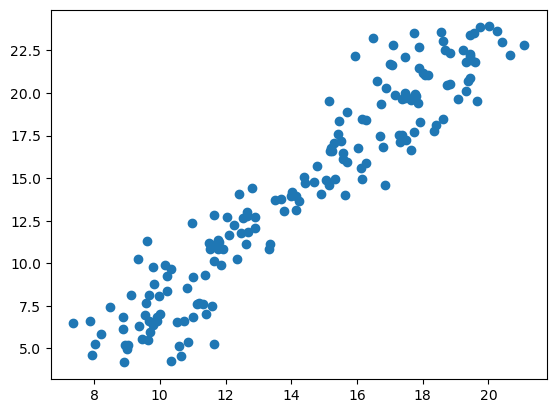

In [401]:
from tensorflow.keras.datasets.mnist import load_data as MNIST
(X,y), (X_test,y_test) = MNIST()
data = X[3103]
proteina = list()
for i,d in enumerate(data):
    for j,c in enumerate(d):
        if c > 100:
            proteina.append([j,len(data) - i])
proteina = np.array(proteina)
proteina = np.concatenate([ proteina + np.random.randn(len(proteina),2) * 0.5 for i in range(3) ], axis = 0)
plt.scatter(proteina[:,0],proteina[:,1])

# Strutture Dati
In questa sezione non facciamo altro che riproporre le strutture dati scritte in C++ ; a livello di algoritmo non ci sono variazioni rispetto al progetto vero e proprio dal momento che il tipo MemoryVector permette un utilizzo trasparente

In [402]:
class BoolVector:
    # fornisce un interfaccia con un oggetto di classe MemoryVector in modo da accedere 
    # ai voxel
    def __init__(self, size, mem_unit):
        # IN : una dimensione
        # OUT: una struttura in grado di maneggiare un np.array come un vector<bool> C++
        self.data = np.zeros( int(size/8) + 1 )
        self.mem_unit = mem_unit
        self.finalized = False
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # IN : coordinata del vettore
        cella   = int(idx / 8)
        settore = (idx % 8)
        binput  = 1 << settore
        return ( (int(self.data[cella]) & binput) > 0 ) 
    
    def __setitem__(self,idx,value):
        # IN : indice , valore
        # OUT: aggiorna il valore
        if self.finalized == True:
            raise Exception("il vettore é stato finalizzato ; non é possibile modificare")
        cella   = int(idx / 8)
        settore = (idx % 8)
        binput  = 1 << settore
        old     = int(self.data[cella]) & binput
        
        self.data[cella] = ( ((value == 1)*255) & ((~old & binput) | old)) | (int(value == 0) & (int(self.data[cella]) & ~binput)) 
    
    def finalize(self):
        # OUT: il vettore che contiene materialmente i dati viene dapprima inizializzato come oggetto di tipo
        #      np.array per rendere agevole; nel momento in cui finalize
        self.data = self.mem_unit.memcopy(self.data)
        self.finalized = True

In [403]:
class VoxelGrid:
    def __init__(self,
                IR,        # rappresentazione intermedia  
                precision, # granularitá della griglia
                mem_unit   # unitá di memoria a supporto dell'oggetto BoolVector
                ):
        
        
        # OUT: produce un vettore che contiene il risultato dell'isomorfismo ipercubo -> vettore.
        #      questo viene copiato nella Unitá di Memoria tramite la funzione MemCopy ; quest'ultima
        #      ritorna un MemoryVector, il cui reference viene passato al costruttore di un oggetto
        #      di classe BoolVector
        
        # inizializzo il boolvector
        
        self.data = BoolVector(precision * precision, mem_unit)
        
        # inizializzo la voxel grid
        self.precision = precision
        self.x_max = IR[:,0].max()      # valore massimo della coordinata x
        self.x_min = IR[:,0].min()      # valore minimo della coordinata x
        self.y_max = IR[:,1].max()      # valore massimo della coordinata y
        self.y_min = IR[:,1].min()      # valore minimo della coordinata y
        self.den_x = self.x_max - self.x_min
        self.den_y = self.y_max - self.y_min
        self.mul_coeff_x = 1. * self.precision / self.den_x
        self.mul_coeff_y = 1. * self.precision / self.den_y 
        
        # popolo la struttura:
        # inizializzazione popolazione
        r        = 1.6
        raggio_x = r * self.mul_coeff_x
        raggio_y = r * self.mul_coeff_y
        #print(raggio_x)
        def valid_range(a,b):
            # produce un range valido per "colorare" gli atomi
            A = np.maximum( a , 0 ).astype(int)
            B = np.minimum( b , self.precision).astype(int)
            return np.arange(A,B)
        
        # per ogni atomo nella proteina
        for v in IR:
            #  setto ad 1 tutti punti che hanno distanza minore di 1.6 armstrong
            x = v[0]
            y = v[1]
            for x_it in valid_range(x - raggio_x, x + raggio_x ):
                for y_it in valid_range(y - raggio_y, y + raggio_y):
                    x_d = (x_it - x)
                    y_d = (y_it - y)
                    #print( float(x_d**2) / raggio_x**2 + float(y_d**2) / raggio_y**2) 
                    if ( float(x_d**2) / raggio_x**2 + float(y_d**2) / raggio_y**2) < 1.0:
                        #print("writing on %d" % (self.precision * x_it + y_it)  )
                        self.data[ self.precision * x_it + y_it ] = 1
                        
        # carico il vettore costruito nella memoria simulata
        self.data.finalize()
        #print("Finish writing and finalizing")
    
    def __getitem__(self, int_coord):
        # IN : coordinate intere all'interno del tensore
        # OUT: presenza / non presenza della proteina nell'entry richiesta
        x,y = int_coord
        return self.data[self.precision * x + y ]

In [404]:
class Structure:
    def __init__(self,
                IR,        # una array di coordinate in R^2 contente la rappresentazione intermedia della proteina
                precision, # granularitá della griglia
                mem_unit   # unitá di memoria a supporto dell'oggetto BoolVector
                ):
        # OUT: un oggetto che permette di accedere ai voxel della proteina per coordinate
        
        self.voxel_grid = VoxelGrid( 
                                      IR,
                                      precision,
                                      mem_unit 
                                   )

        
    def __getitem__(self, real_coord):
        # IN : coordinate in R^2
        # OUT: presenza / non presenza della proteina nel punto richiesto
        x,y = real_coord
        i   = int( (x - self.voxel_grid.x_min ) * self.voxel_grid.mul_coeff_x )
        j   = int( (y - self.voxel_grid.y_min)  * self.voxel_grid.mul_coeff_y )
        
        if i < 0 or i >= self.voxel_grid.precision:
                return 0
        if j < 0 or j >= self.voxel_grid.precision:
                return 0
        return self.voxel_grid[i,j]

Esempio di accesso:

In [405]:
M = MemoryUnit(20,100,10)  
A = Structure(proteina,50,M)
A[1,2]

0

Plot del contenuto di $BoolVector$ (semplice check per verificare che la struttura non sia vuota)

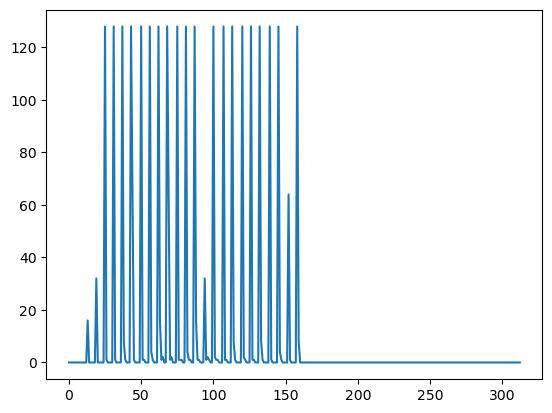

In [406]:
v = A.voxel_grid.data.mem_unit.memory.data
plt.plot( v.flatten()[:len(A.voxel_grid.data)] )

# Rotation Test

## Test senza rotazione
Facciamo un test con la proteina "plain" : carichiamo la proteina in memoria ed eseguiamo l'algoritmo di consultazione.
L'algoritmo di consultazione tenta di ricalcare il percorso che farebbe un algoritmo di consultazione in stile annealing come un algoritmo genetico. L'idea é quella di selezionare un punto dalla rappresentazione come lista di punti in $\mathbb R^3$ (in questo specifico caso $\mathbb R^2$) della proteina e di estrarre un punto in un intorno gaussiano di questo punto. In questo modo tentiamo di ricalcare la distribuzione statistica delle estrazioni di punti, mantenendo comunque un approccio molto conservativo sulla assunzione di "distanza piccola" dei punti selezionati (che in contesti come l'annealing o le prime fasi degli algoritmi genetici risulta essere non sempre soddisfatta)

## Costruisco memoria e struttura

In [407]:
M = MemoryUnit(64,256,8)  
# costruisco la struttura
proteina_zc = proteina - proteina.mean(axis = 0)
A = Structure( proteina_zc,100,M)

In [408]:
# resetto la cache
M.cache.flush()
x = proteina_zc.mean(axis = 0)
for i in range(100000):
    x = proteina_zc[np.random.choice(len(proteina))] * 0.9 + np.random.randn(2) * 0.1
    val = A[x]
    if i % 1000 == 0:
        print("coords = %.3f     %.3f \t hits = %d \t \t miss = %d \t value = %d " % (x[0],x[1],M.cache.hits, M.cache.misses,val ) )


coords = -4.914     -8.279 	 hits = 0 	 	 miss = 1 	 value = 0 
coords = 1.301     4.057 	 hits = 512 	 	 miss = 489 	 value = 0 
coords = -2.562     -6.583 	 hits = 1034 	 	 miss = 967 	 value = 0 
coords = -0.248     -0.351 	 hits = 1532 	 	 miss = 1469 	 value = 0 
coords = 1.972     8.095 	 hits = 2030 	 	 miss = 1971 	 value = 0 
coords = 2.576     6.680 	 hits = 2539 	 	 miss = 2462 	 value = 0 
coords = 4.372     5.246 	 hits = 3051 	 	 miss = 2950 	 value = 0 
coords = 0.112     0.394 	 hits = 3561 	 	 miss = 3440 	 value = 0 
coords = -0.038     -0.732 	 hits = 4064 	 	 miss = 3937 	 value = 0 
coords = -1.635     -0.323 	 hits = 4598 	 	 miss = 4403 	 value = 0 
coords = 4.189     5.523 	 hits = 5086 	 	 miss = 4915 	 value = 0 
coords = 1.145     3.187 	 hits = 5605 	 	 miss = 5396 	 value = 0 
coords = 0.449     -0.180 	 hits = 6129 	 	 miss = 5872 	 value = 0 
coords = 2.991     4.762 	 hits = 6635 	 	 miss = 6366 	 value = 0 
coords = 1.777     0.450 	 hits = 7141 	 	 mis

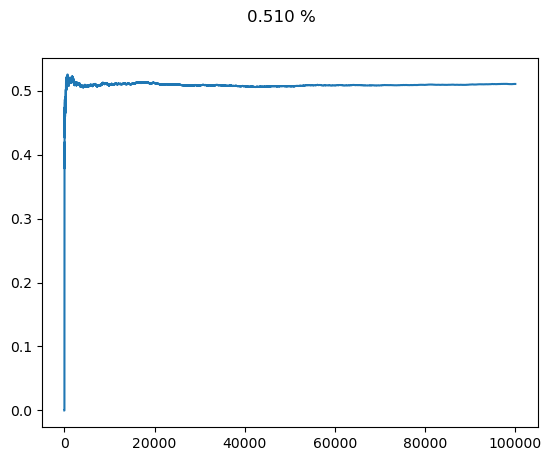

In [409]:
H = np.array(M.cache.history)
hit_access_ratio_no_rotation =  H[1:,0] / (H[1:,0] + H[1:,1])
plt.plot( hit_access_ratio_no_rotation )
plt.suptitle( "%.3f %%" % hit_access_ratio_no_rotation[-1])
plt.show()

## Test Rotazione
Questo test viene eseguito ruotando la proteina in modo da favorire la direzione principale.
Lo stesso test mostrato al passo precedente viene riprodotto in questa nuova variante, che altro non é di fatti che una variazione di sistema di riferimento della rappresentazione originale della proteina (che risulta essere un passaggio valido nel contesto del molecular docking dato che la fase di ottimizzazione deve essere invariante rispetto alla posizione e la rotazione della proteina nello spazio )

In [410]:
M = MemoryUnit(64,256,8) 
# capacitá memoria = 16384 voxel
# capacitá cache   = 4096 voxel

proteina_zc = proteina - proteina.mean(axis = 0)
# costruisco la struttura con la proteina proiettata
U,s,Vt = np.linalg.svd(proteina_zc, full_matrices = False)
print(s)
proteina_ruotata = proteina_zc @ Vt.T[:,[1,0]]
A = Structure( proteina_ruotata,100,M)

[89.82162291 12.78970958]


In [411]:
# resetto la cache
M.cache.flush()
for i in range(100000):
    x = proteina_ruotata[np.random.choice(len(proteina))] * 0.9  + np.random.randn(2) * 0.1
    val = A[x] 
    if i % 1000 == 0:
        print("coords = %.3f     %.3f \t hits = %d \t \t miss = %d \t value = %d " % (x[0],x[1],M.cache.hits, M.cache.misses,  val) )


coords = -0.194     -0.582 	 hits = 0 	 	 miss = 1 	 value = 0 
coords = -0.191     -10.058 	 hits = 628 	 	 miss = 373 	 value = 0 
coords = 0.040     4.477 	 hits = 1280 	 	 miss = 721 	 value = 0 
coords = -0.788     -3.210 	 hits = 1917 	 	 miss = 1084 	 value = 0 
coords = -0.933     -7.538 	 hits = 2560 	 	 miss = 1441 	 value = 0 
coords = -1.561     8.492 	 hits = 3195 	 	 miss = 1806 	 value = 0 
coords = 1.210     0.757 	 hits = 3837 	 	 miss = 2164 	 value = 0 
coords = 1.183     -7.048 	 hits = 4488 	 	 miss = 2513 	 value = 0 
coords = -0.976     -7.173 	 hits = 5115 	 	 miss = 2886 	 value = 0 
coords = -0.480     -3.509 	 hits = 5707 	 	 miss = 3294 	 value = 0 
coords = 1.267     5.609 	 hits = 6326 	 	 miss = 3675 	 value = 0 
coords = 1.774     -7.758 	 hits = 6964 	 	 miss = 4037 	 value = 0 
coords = 0.385     9.788 	 hits = 7606 	 	 miss = 4395 	 value = 0 
coords = 1.241     1.044 	 hits = 8230 	 	 miss = 4771 	 value = 0 
coords = 1.122     0.627 	 hits = 8867 	 

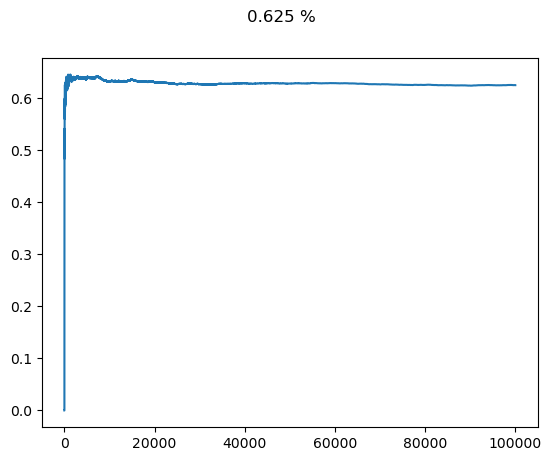

In [412]:
H = np.array(M.cache.history)
hit_access_ratio_rotation =  H[1:,0] / (H[1:,0] + H[1:,1])
plt.plot( hit_access_ratio_rotation )
plt.suptitle( "%.3f %%" % hit_access_ratio_rotation[-1])
plt.show()

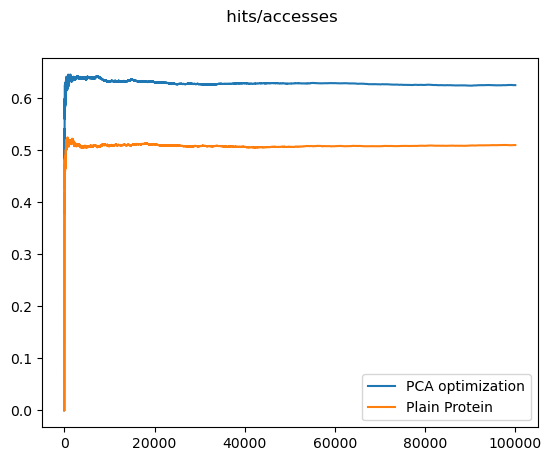

In [413]:
plt.suptitle(" hits/accesses ")
plt.plot( hit_access_ratio_rotation )
plt.plot( hit_access_ratio_no_rotation )
plt.legend(["PCA optimization","Plain Protein"])

# Test SQUARE VOXELS
Viene fatto un ulteriore test: anziché la rotazione che favorisce la direzione principale consideriamo la rotazione che minimizza la differenza tra l'altezza e la larghezza dei voxel. 
Il calcolo di questa rotazione viene calcolata scrivendo una funzione di costo ad hoc e utilizzando il tool di differenziazione automatica $JAX$

In [414]:
def get_w(proteina):
    return jnp.abs( proteina[:,0].max() - proteina[:,0].min() )

def  ruota(theta,proteina):
    M = jnp.array([ 
        [ jnp.cos(theta), - jnp.sin(theta) ],
        [ jnp.sin(theta) , jnp.cos(theta)  ]
    ])
    return (proteina - proteina.mean(axis = 0)) @ M + proteina.mean(axis = 0)

def loss(theta,proteina):
    return get_w(ruota(theta,proteina))

loss( 0.3, proteina)
loss = jax.jit(loss)
grad = jax.grad(loss)
grad = jax.jit(grad)

In [415]:
theta = 0.
mom   = theta * 0 
for i in range(10000):
    mom = .9 * mom - 0.0001 * grad(theta, proteina)
    theta = theta + mom
    if i % 1000 == 0:
        print(loss(theta,proteina))

13.69199
4.7614193
4.763036
4.763998
4.7620554
4.765746
4.7586946
4.769532
4.764805
4.7632694


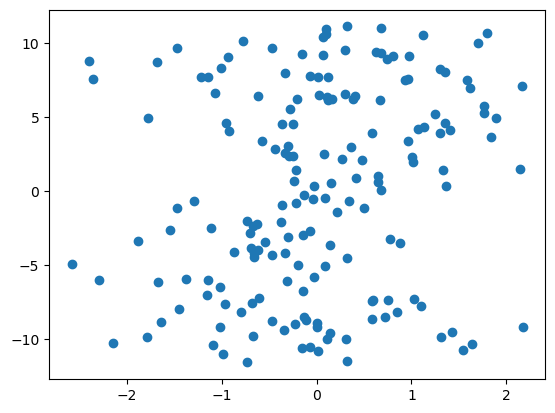

In [416]:
proteina_ruotata = ruota(theta,proteina)
proteina_ruotata = proteina_ruotata - np.mean(proteina_ruotata,axis = 0)
proteina_ruotata = np.array(proteina_ruotata)
plt.scatter(proteina_ruotata[:,0],proteina_ruotata[:,1])

Riproponiamo il test illustrato ai passi precedenti

In [417]:
# resetto la cache
M = MemoryUnit(64,256,8)  
A = Structure( proteina_ruotata,100,M)
M.cache.flush()
for i in range(100000):
    x = proteina_ruotata[np.random.choice(len(proteina))] * 0.9  + np.random.randn(2) * 0.1
    val = A[x] 
    if i % 1000 == 0:
        print("coords = %.3f     %.3f \t hits = %d \t \t miss = %d \t value = %d " % (x[0],x[1],M.cache.hits, M.cache.misses,  val) )

coords = -1.664     4.440 	 hits = 0 	 	 miss = 1 	 value = 0 
coords = 0.120     -9.723 	 hits = 586 	 	 miss = 415 	 value = 0 
coords = 0.707     5.704 	 hits = 1152 	 	 miss = 849 	 value = 0 
coords = 0.232     -9.088 	 hits = 1709 	 	 miss = 1292 	 value = 0 
coords = -0.195     -0.310 	 hits = 2279 	 	 miss = 1722 	 value = 0 
coords = 0.350     -10.226 	 hits = 2854 	 	 miss = 2147 	 value = 0 
coords = -0.034     6.897 	 hits = 3435 	 	 miss = 2566 	 value = 0 
coords = -0.826     7.649 	 hits = 4051 	 	 miss = 2950 	 value = 0 
coords = 1.208     3.859 	 hits = 4589 	 	 miss = 3412 	 value = 0 
coords = 0.125     1.878 	 hits = 5168 	 	 miss = 3833 	 value = 0 
coords = -0.869     -10.020 	 hits = 5741 	 	 miss = 4260 	 value = 0 
coords = -2.181     -5.235 	 hits = 6322 	 	 miss = 4679 	 value = 0 
coords = 1.392     -9.283 	 hits = 6904 	 	 miss = 5097 	 value = 0 
coords = -0.229     -2.804 	 hits = 7482 	 	 miss = 5519 	 value = 0 
coords = 0.842     8.076 	 hits = 8054 	

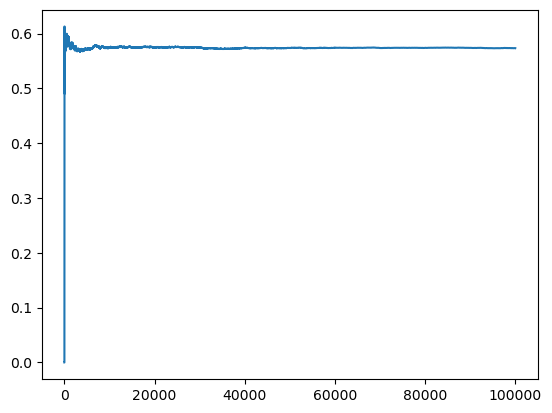

In [418]:
H = np.array(M.cache.history)
hit_access_ratio_equal_rotation =  H[1:,0] / (H[1:,0] + H[1:,1])
plt.plot( hit_access_ratio_equal_rotation )

Come possiamo osservare , la rotazione descritta dalle componenti principali risulta essere la piu vantaggiosa nel contesto della massimizzazione del rapporto $hits/accesses$

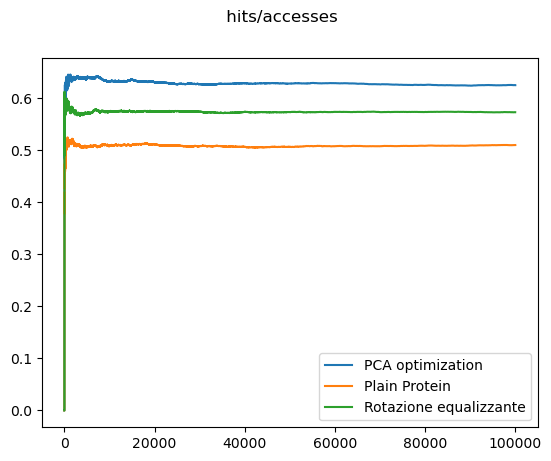

In [419]:
plt.suptitle(" hits/accesses ")
plt.plot( hit_access_ratio_rotation )
plt.plot( hit_access_ratio_no_rotation )
plt.plot( hit_access_ratio_equal_rotation )
plt.legend(["PCA optimization","Plain Protein","Rotazione equalizzante"])